In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import itertools
import cv2

In [ ]:
DATA_ROOT = "D:/ANNA/dr"
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR = os.path.join(DATA_ROOT, "val")
TEST_DIR = os.path.join(DATA_ROOT, "test")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
MODEL_SAVE = "mobilenetv2_dr_imp.h5"
LOG_DIR = "./logs/mobilenetv2"

In [ ]:
# description of the dataset
DATASET_SOURCE = "https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-gaussian-filtered')" 

def print_dataset_info():
    print("Dataset source:", DATASET_SOURCE)
    print("Train, Val, Test directories:", TRAIN_DIR, VAL_DIR, TEST_DIR)
    for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
        for c in sorted(os.listdir(d)):
            path = os.path.join(d,c)
            if os.path.isdir(path):
                n = len([f for f in os.listdir(path) if f.lower().endswith(('.png','.jpg','.jpeg'))])
                print(f"{d}/{c} -> {n} images")

In [ ]:
# data cleaning: remove unreadable/corrupted images
def remove_unreadable_images(root_dirs):
    import PIL.Image as Image
    bad = []
    for root in root_dirs:
        for cls in os.listdir(root):
            cls_path = os.path.join(root, cls)
            if not os.path.isdir(cls_path): continue
            for fname in os.listdir(cls_path):
                fp = os.path.join(cls_path, fname)
                try:
                    Image.open(fp).verify()
                except Exception as e:
                    bad.append(fp)
    if bad:
        print("Unreadable or corrupted files found (list):")
        for p in bad:
            print("  ", p)
    else:
        print("No corrupted images found.")
    return bad

In [ ]:
# augmented train generator, simple val/test generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True
)
val_gen = val_datagen.flow_from_directory(
    VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)
test_gen = test_datagen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

num_classes = train_gen.num_classes
class_indices = train_gen.class_indices
inv_class_indices = {v:k for k,v in class_indices.items()}
print("Class indices:", class_indices)

Found 1947 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Class indices: {'DR': 0, 'No_DR': 1}


In [ ]:
# compute class weights to handle class imbalance
labels_list = []
for c, count in train_gen.class_indices.items():
    pass
# to compute class weights we need the labels vector:
y_train_labels = train_gen.classes  # numeric labels
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(1.4232456140350878), 1: np.float64(0.7707838479809976)}


Dataset source: https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-gaussian-filtered')
Train, Val, Test directories: D:/ANNA/dr\train D:/ANNA/dr\val D:/ANNA/dr\test
D:/ANNA/dr\train/DR -> 684 images
D:/ANNA/dr\train/No_DR -> 1263 images
D:/ANNA/dr\val/DR -> 279 images
D:/ANNA/dr\val/No_DR -> 271 images
D:/ANNA/dr\test/DR -> 279 images
D:/ANNA/dr\test/No_DR -> 271 images
No corrupted images found.


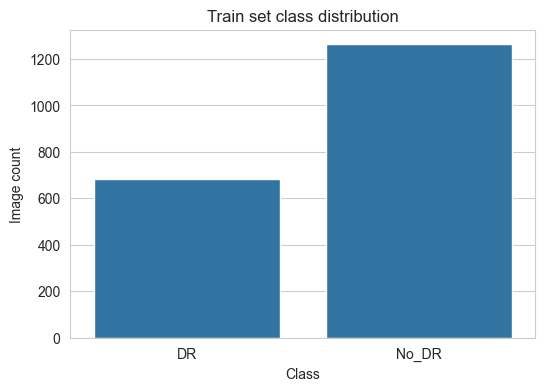

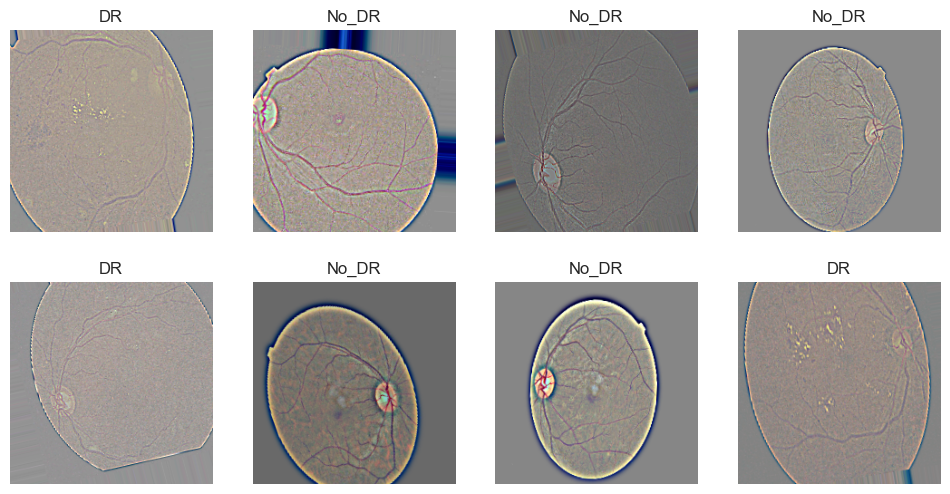

In [ ]:
# EDA
def plot_class_distribution(train_gen):
    names = list(class_indices.keys())
    counts = [len(os.listdir(os.path.join(TRAIN_DIR,c))) for c in names]
    plt.figure(figsize=(6,4))
    sns.barplot(x=names, y=counts)
    plt.title("Train set class distribution")
    plt.ylabel("Image count")
    plt.xlabel("Class")
    plt.show()

def show_sample_images(gen, n=6):
    x,y = next(gen)
    plt.figure(figsize=(12,6))
    for i in range(n):
        ax = plt.subplot(2, n//2, i+1)
        plt.imshow(x[i])
        cls = inv_class_indices[np.argmax(y[i])]
        plt.title(cls)
        plt.axis('off')
    plt.show()

print_dataset_info()
bad_files = remove_unreadable_images([TRAIN_DIR, VAL_DIR, TEST_DIR])
plot_class_distribution(train_gen)
show_sample_images(train_gen, n=8)

In [ ]:
# model building: MobileNetV2 base + custom head
# Math docstring (rubric): basic CNN conv layer operation:
#   (I * K)(x,y) = sum_{i,j} I(x+i, y+j) * K(i,j)
# followed by non-linearity (ReLU) and pooling.
# MobileNetV2 justification:
#  - Depthwise separable convs reduce parameters: standard conv cost ~ Dk*Dk*M*N, 
#    depthwise separable: Dk*Dk*M + M*N (significantly smaller).
#  - Good tradeoff: lightweight and performs well on classification tasks where model size matters.

base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base.trainable = False  # freeze initial training

def build_model(num_classes, base_model=base, dropout=0.4):
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

model = build_model(num_classes)
model.summary()

# compile
# Loss: categorical_crossentropy (multiclass prob dist via softmax)
# Optimizer: Adam with lr scheduling (ReduceLROnPlateau)
initial_lr = 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# callbacks
tb_cb = callbacks.TensorBoard(LOG_DIR)
mc_cb = callbacks.ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
es_cb = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
rlr_cb = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,591,554 (9.89 MB)

 Trainable params: 331,010 (1.26 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [ ]:
# training
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[tb_cb, mc_cb, es_cb, rlr_cb]
)

# save model
model.save(MODEL_SAVE)

C:\Users\Hrutuj Turankar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.6584 - loss: 0.8064
Epoch 1: val_accuracy improved from None to 0.94909, saving model to best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 49s 694ms/step - accuracy: 0.7678 - loss: 0.5685 - val_accuracy: 0.9491 - val_loss: 0.3215 - learning_rate: 1.0000e-04
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.8836 - loss: 0.3818
Epoch 2: val_accuracy did not improve from 0.94909
61/61 ━━━━━━━━━━━━━━━━━━━━ 39s 641ms/step - accuracy: 0.8942 - loss: 0.3571 - val_accuracy: 0.9436 - val_loss: 0.2626 - learning_rate: 1.0000e-04
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.9075 - loss: 0.3349
Epoch 3: val_accuracy improved from 0.94909 to 0.96182, saving model to best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 38s 627ms/step - accuracy: 0.9076 - loss: 0.3232 - val_accuracy: 0.9618 - val_loss: 0.2169 - learning_rate: 1.0000e-04
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.9120 - loss: 0.3235
Epoch 4: val_accuracy improved from 0.96182 to 0.96545, saving model to best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 40s 648ms/step - accuracy: 0.9147 - loss: 0.3237 - val_accuracy: 0.9655 - val_loss: 0.1875 - learning_rate: 1.0000e-04
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.9173 - loss: 0.3221
Epoch 5: val_accuracy improved from 0.96545 to 0.97091, saving model to best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 40s 649ms/step - accuracy: 0.9199 - loss: 0.3056 - val_accuracy: 0.9709 - val_loss: 0.1732 - learning_rate: 1.0000e-04
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.9325 - loss: 0.2768
Epoch 6: val_accuracy did not improve from 0.97091
61/61 ━━━━━━━━━━━━━━━━━━━━ 40s 655ms/step - accuracy: 0.9286 - loss: 0.2837 - val_accuracy: 0.9709 - val_loss: 0.1584 - learning_rate: 1.0000e-04
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.9265 - loss: 0.2844
Epoch 7: val_accuracy did not improve from 0.97091
61/61 ━━━━━━━━━━━━━━━━━━━━ 40s 646ms/step - accuracy: 0.9317 - loss: 0.2688 - val_accuracy: 0.9691 - val_loss: 0.1516 - learning_rate: 1.0000e-04
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.9216 - loss: 0.2978
Epoch 8: val_accuracy did not improve from 0.97091
61/61 ━━━━━━━━━━━━━━━━━━━━ 39s 631ms/step - accuracy: 0.9199 - loss: 0.2886 - val_accuracy: 0.9709 - val_loss: 0.1513 - learning_rate: 1.0000e-04
Epoch

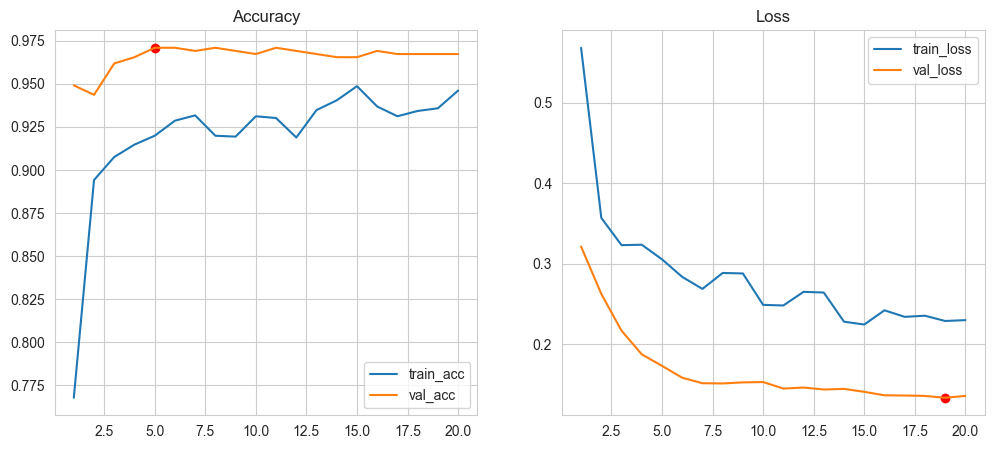

In [ ]:
# accuracy and loss plots
def plot_history(history):
    h = history.history
    epochs_range = range(1, len(h['loss'])+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, h['accuracy'], label='train_acc')
    plt.plot(epochs_range, h['val_accuracy'], label='val_acc')
    plt.scatter(np.argmax(h['val_accuracy'])+1, np.max(h['val_accuracy']), color='red')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs_range, h['loss'], label='train_loss')
    plt.plot(epochs_range, h['val_loss'], label='val_loss')
    plt.scatter(np.argmin(h['val_loss'])+1, np.min(h['val_loss']), color='red')
    plt.title('Loss')
    plt.legend()
    plt.show()

plot_history(history)

18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 363ms/step


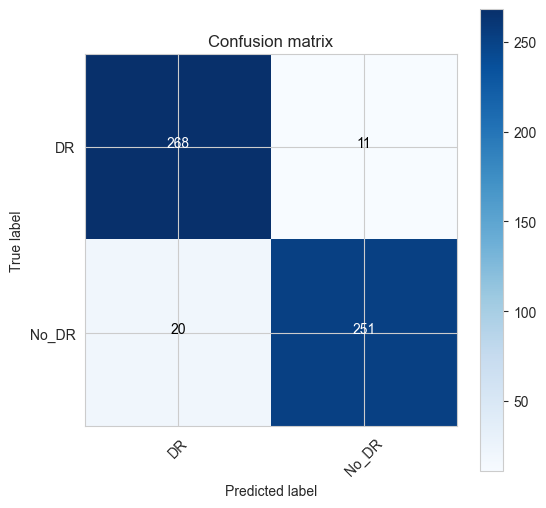

Classification Report:

              precision    recall  f1-score   support

          DR       0.93      0.96      0.95       279
       No_DR       0.96      0.93      0.94       271

    accuracy                           0.94       550
   macro avg       0.94      0.94      0.94       550
weighted avg       0.94      0.94      0.94       550



In [ ]:
# evaluation: confusion matrix and classification report
# load best saved model for evaluation
best = tf.keras.models.load_model('best_model.h5')

# predict on test set
preds = best.predict(test_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, list(class_indices.keys()), rotation=45)
plt.yticks(tick_marks, list(class_indices.keys()))
thresh = cm.max() / 2.
for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i,j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i,j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=list(class_indices.keys())))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


C:\Users\Hrutuj Turankar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


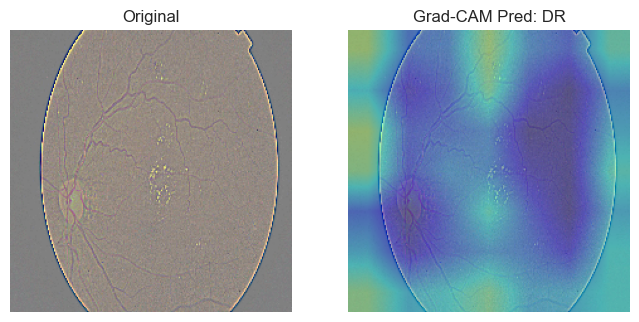

All done. Model saved to: mobilenetv2_dr_imp.h5


In [ ]:
# Grad-CAM implementation
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # img_array: (1, h, w, 3) already scaled [0,1]
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, model, last_conv_layer_name="Conv_1", alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, IMG_SIZE)
    img_array = np.expand_dims(img_resized/255.0, axis=0)
    preds = model.predict(img_array)
    pred_idx = np.argmax(preds[0])
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_idx)
    heatmap = cv2.resize(heatmap, (img_resized.shape[1], img_resized.shape[0]))
    heatmap = np.uint8(255*heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img_resized, 0.6, heatmap_color, alpha, 0)
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img_resized)
    plt.axis('off')
    plt.title('Original')
    plt.subplot(1,2,2)
    plt.imshow(superimposed)
    plt.axis('off')
    plt.title(f'Grad-CAM Pred: {inv_class_indices[pred_idx]}')
    plt.show()

# sample from test folder
sample_img = 'test/No_DR/0dbe6c26cedc.png'
for cls in os.listdir(TEST_DIR):
    cls_path = os.path.join(TEST_DIR, cls)
    if os.path.isdir(cls_path):
        files = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg','.png','.jpeg'))]
        if files:
            sample_img = os.path.join(cls_path, files[0])
            break
if sample_img:
    save_and_display_gradcam(sample_img, best, last_conv_layer_name='Conv_1')  # MobileNetV2 last conv: Conv_1

print("All done. Model saved to:", MODEL_SAVE)